In [1]:
import numpy as np
import pandas as pd
import Easy_Risk_Kit as erk
import matplotlib.pyplot as plt 
import seaborn as  sns
%load_ext autoreload
%autoreload 2
%matplotlib inline




floor allocator gets youncloser to the floor by allocating more to zero coupn bond( duration matched portfolio), 
as we get closer to the floor valur

In [2]:
n_scenarios=5000
rates, zc_prices=erk.cir(10, n_scenarios=n_scenarios, b=0.03, r_0=0.03, sigma=0.02)
price_eq=erk.gbm(n_years=10, n_scenarios=n_scenarios, mu=0.07, sigma=0.15)

DYNAMIC RISK BUDGETING

In [6]:
rets_eq=price_eq.pct_change().dropna()
rets_zc=zc_prices.pct_change().dropna()
rets_7030b=erk.bt_mix(rets_eq, rets_zc, allocator=erk.fixedmix_allocator, w1=0.7)

pd.concat([
    erk.terminal_stats(rets_zc, name="ZC", floor=0.75), 
    erk.terminal_stats(rets_eq, name="Eq", floor=0.75),
    erk.terminal_stats(rets_7030b, name="70/30", floor=0.75)]
, axis=1).round(2)

,ZC,Eq,70/30
mean,1.34,1.96,1.75
std,0.00,0.96,0.59
p_breach,NaN,0.04,0.01
e_short,NaN,0.12,0.07
p_reach,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN


I am goinf to try and fix the breach 

In [10]:
def floor_allocator(psp_r, ghp_r, floor, zc_prices, m=3):
    if zc_prices.shape != psp_r.shape:
        raise ValueError("PSP and ZC prices mst have the same shape")
    n_steps, n_scenarios=psp_r.shape
    account_value=np.repeat(1, n_scenarios)
    floor_value=np.repeat(1, n_scenarios)
    w_history=pd.DataFrame(index=psp_r.index, columns=psp_r.columns)
    for step in range(n_steps):
        floor_value=floor*zc_prices.iloc[step] 
        cushion=(account_value-floor_value)/account_value
        psp_w=(m*cushion).clip(0, 1)
        ghp_w=1-psp_w
        psp_alloc=account_value*psp_w
        ghp_alloc=account_value*ghp_w
        account_value=psp_alloc*(1+psp_r.iloc[step])+ghp_alloc*(1+ghp_r.iloc[step])
        w_history.iloc[step]=psp_w
    return w_history

In [11]:
rets_floor75=erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, floor=0.75, zc_prices=zc_prices[1:])

pd.concat([
    erk.terminal_stats(rets_zc, name="ZC", floor=0.75), 
    erk.terminal_stats(rets_eq, name="Eq", floor=0.75),
    erk.terminal_stats(rets_7030b, name="70/30", floor=0.75),
    erk.terminal_stats(rets_floor75, name="Floor75", floor=0.75),
],
axis=1).round(2)

,ZC,Eq,70/30,Floor75
mean,1.34,1.96,1.75,1.93
std,0.00,0.96,0.59,0.96
p_breach,NaN,0.04,0.01,NaN
e_short,NaN,0.12,0.07,NaN
p_reach,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN


In [13]:
rets_floor75m1=erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, floor=0.75, zc_prices=zc_prices[1:], m=1)
rets_floor75m1=erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, floor=0.75, zc_prices=zc_prices[1:], m=5)
pd.concat([
    erk.terminal_stats(rets_zc, name="ZC", floor=0.75), 
    erk.terminal_stats(rets_eq, name="Eq", floor=0.75),
    erk.terminal_stats(rets_7030b, name="70/30", floor=0.75),
    erk.terminal_stats(rets_floor75, name="Floor75m1", floor=0.75),
    erk.terminal_stats(rets_floor75, name="Floor75m2", floor=0.75),
],

axis=1).round(2)


,ZC,Eq,70/30,Floor75m1,Floor75m2
mean,1.34,1.96,1.75,1.93,1.93
std,0.00,0.96,0.59,0.96,0.96
p_breach,NaN,0.04,0.01,NaN,NaN
e_short,NaN,0.12,0.07,NaN,NaN
p_reach,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN


In [14]:
pd.concat([
    erk.terminal_stats(rets_zc, name="ZC", floor=0.75), 
    erk.terminal_stats(rets_eq, name="Eq", floor=0.75),
    erk.terminal_stats(rets_7030b, name="70/30", floor=0.75),
    erk.terminal_stats(rets_floor75, name="Floor75m1", floor=0.75),
    erk.terminal_stats(rets_floor75, name="Floor75m2", floor=0.75),
],

axis=1).round(4)

,ZC,Eq,70/30,Floor75m1,Floor75m2
mean,1.3433,1.9583,1.7508,1.9333,1.9333
std,0.0000,0.9582,0.5850,0.9649,0.9649
p_breach,NaN,0.0356,0.0076,NaN,NaN
e_short,NaN,0.1167,0.0694,NaN,NaN
p_reach,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN


Risk budgetting with dradown constraint

In [21]:
cashrate=0.02
monthly_cashreturn=(1+cashrate)**(1/12)-1
rets_cash=pd.DataFrame(data=monthly_cashreturn, index=rets_eq.index, columns=rets_eq.columns)
rets_maxdd25=erk.bt_mix(rets_eq, rets_cash, allocator=erk.drawdown_allocator, maxdd=.25)
tv_maxdd25=erk.terminal_values(rets_maxdd25)
pd.concat([
    erk.terminal_stats(rets_zc, name="ZC", floor=0.75), 
    erk.terminal_stats(rets_eq, name="Eq", floor=0.75),
    erk.terminal_stats(rets_7030b, name="70/30", floor=0.75),
    erk.terminal_stats(rets_floor75, name="Floor75m1", floor=0.75),
    erk.terminal_stats(rets_floor75, name="Floor75m5", floor=0.75),
    erk.terminal_stats(rets_maxdd25, name="Maxdd25", floor=0.75),
],

axis=1).round(2)


,ZC,Eq,70/30,Floor75m1,Floor75m5,Maxdd25
mean,1.34,1.96,1.75,1.93,1.93,1.62
std,0.00,0.96,0.59,0.96,0.96,0.53
p_breach,NaN,0.04,0.01,NaN,NaN,NaN
e_short,NaN,0.12,0.07,NaN,NaN,NaN
p_reach,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
erk.summary_stats(rets_maxdd25)["Max Drawdown"].head()

0   -0.138502
1   -0.192998
2   -0.136236
3   -0.109301
4   -0.150259
Name: Max Drawdown, dtype: float64

In [23]:
erk.summary_stats(rets_maxdd25)["Max Drawdown"].min()

-0.23565268397794942

In [26]:
#

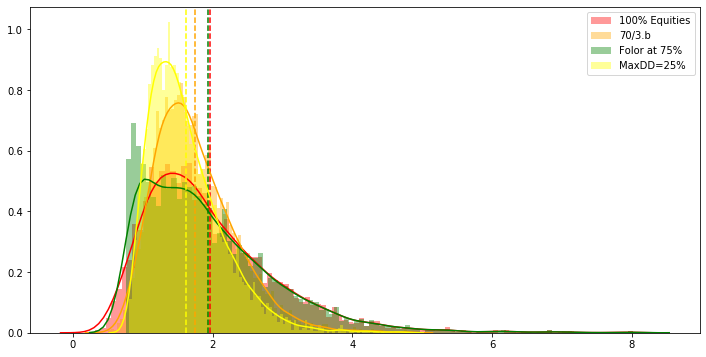

In [25]:
tv_eq=erk.terminal_values(rets_eq)
tv_zc=erk.terminal_values(rets_zc)
tv_7030b=erk.terminal_values(rets_7030b)
tv_floor75=erk.terminal_values(rets_floor75)
tv_maxdd25=erk.terminal_values(rets_maxdd25)
#plot
plt.figure(figsize=(12,6))
sns.distplot(tv_eq, color="red", label="100% Equities", bins=100)
plt.axvline(tv_eq.mean(), ls="--", color="red")
sns.distplot(tv_7030b, color="orange", label="70/3.b", bins=100)
plt.axvline(tv_7030b.mean(), ls="--", color="orange")
sns.distplot(tv_floor75, color="green", label="Folor at 75%", bins=100)
plt.axvline(tv_floor75.mean(), ls="--", color="green")
sns.distplot(tv_maxdd25, color="yellow", label="MaxDD=25%", bins=100)
plt.axvline(tv_maxdd25.mean(), ls="--", color="yellow")
plt.legend();

#Drawdown constraint with Historical Data

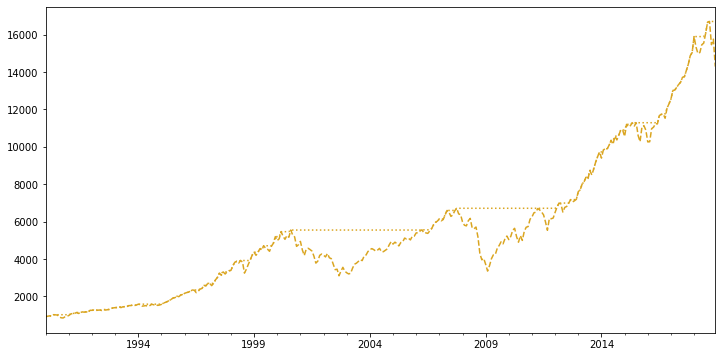

In [36]:
rets_tmi=erk.get_tmi_rets()["1990":]
dd_tmi=erk.drawdown(rets_tmi)
ax=dd_tmi["wealth"].plot(figsize=(12,6) ,ls="--", color="goldenrod")
dd_tmi["peaks"].plot(ax=ax, ls=":", color="goldenrod")

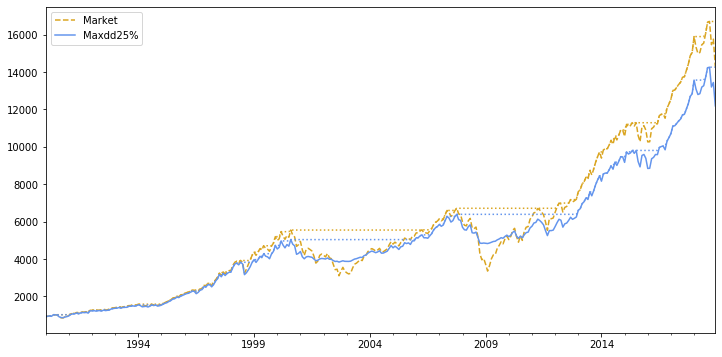

In [37]:
cashrate=0.03
monthly_cashreturn=(1+cashrate)**(1/12)-1
rets_cash=pd.DataFrame(data=monthly_cashreturn, index=rets_tmi.index, columns=[0])
rets_maxdd25=erk.bt_mix(pd.DataFrame(rets_tmi),rets_cash, allocator=erk.drawdown_allocator, maxdd=.25, m=5)
dd_25=erk.drawdown(rets_maxdd25[0])

ax=dd_tmi["wealth"].plot(figsize=(12,6) ,ls="--", color="goldenrod", label="Market", legend=True)
dd_tmi["peaks"].plot(ax=ax, ls=":", color="goldenrod")
dd_25["wealth"].plot(ax=ax, label="Maxdd25%",color="cornflowerblue", legend=True )
dd_25["peaks"].plot(ax=ax, ls=":", color="cornflowerblue")

In [39]:
erk.summary_stats(pd.concat([rets_tmi.rename("Market"), rets_maxdd25[0].rename("MaxdDD")], axis=1)

SyntaxError: unexpected EOF while parsing (<ipython-input-39-fb126a435f09>, line 1)